# Brazil E-Commerce Data Analysis

This is a Brazilian ecommerce public dataset of orders made at Olist Store. 
    
The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. 

Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers

This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

# Data Schema

The data is divided in multiple datasets for better understanding and organization. Please refer to the following data schema when working with it:

<p><img src= "Images/Data_Model.png"/></p>

This dataset provides a lot of posibilities of use cases for Machine Learning and Data analysis.

Here are some of the possibilities that can be explored using this dataset: 
    
- Natural Language Processing (NLP): understanding the reviews provided by the customers through multiple dimensions

- Clustering: some customers did not provide reviews, but were they happy or not ?
    
- Sales Prediction: with the sales dates, can we be able to predict future sales ?
    
- Delivery performance: can we be able to optimize the delivery times
    
- Product Quality: which product categories are more prone to customer insatisfaction

- Feature engineering: attach some public information into this dataset or generate features from it

<h5>What about using SQL and Metabase for analysis ? </h5>

<p>This is a feasible approach since we can use SQL to analyze the data and create sharable dashboards using Metabase.

That will require the data to be modelled into our database before the analysis can begin</p>

The aim of this kernel is: 
    

<p>1. Understand the customer reviews using NLP techniques.</p>
<p>2. Create an interactive data analysis dashboard using Metabase that uncovers trends in sales patterns</p>


### Reading the data

In [14]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import requests
import json

from collections import Counter
from PIL import Image
from viz_utils import *

import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go

In [2]:
data_path = "data/"
olist_customer = pd.read_csv(data_path + 'olist_customers_dataset.csv')
olist_geolocation = pd.read_csv(data_path + 'olist_geolocation_dataset.csv')
olist_order_items = pd.read_csv(data_path + 'olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv(data_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(data_path + 'olist_order_reviews_dataset.csv')
olist_orders = pd.read_csv(data_path + 'olist_orders_dataset.csv')
olist_products = pd.read_csv(data_path + 'olist_products_dataset.csv')
olist_sellers = pd.read_csv(data_path + 'olist_sellers_dataset.csv')
olist_product_naming = pd.read_csv(data_path + 'product_category_name_translation.csv')

brazil_adm = gpd.read_file(data_path+'BRA_adm1.shp')
adm_csv = pd.read_csv(data_path+'BRA_adm1.csv')

In [3]:
datasets = [olist_customer, olist_geolocation, olist_orders, 
            olist_order_items, olist_order_payments,olist_order_reviews,
            olist_products, olist_sellers, olist_product_naming, brazil_adm, adm_csv
           ]

names = ['olist_customer', 'olist_geolocation', 'olist_orders', 
            'olist_order_items', 'olist_order_payments','olist_order_reviews',
            'olist_products', 'olist_sellers', 'olist_product_naming', 'brazil_adm', 'adm_csv']

## Create a dictionary with useful information about the nature of all the datasets
data_view = pd.DataFrame({})
data_view['dataset'] = names
data_view['n_rows'] = [df.shape[0] for df in datasets]
data_view['n_cols'] = [df.shape[1] for df in datasets]
data_view['null_values'] = [df.isnull().sum().sum() for df in datasets]

data_view['number_of_nul_cols'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_view['null_columns'] = [','.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

In [4]:
[col for col, no_nulls in olist_products.isnull().sum().items() if no_nulls > 0]

['product_category_name',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm']

In [5]:
data_view.style.highlight_between()

,dataset,n_rows,n_cols,null_values,number_of_nul_cols,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at,order_delivered_carrier_date,order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,99224,7,145903,2,"review_comment_title,review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm"
7,olist_sellers,3095,4,0,0,
8,olist_product_naming,71,2,0,0,
9,brazil_adm,27,13,68,3,"CCA_1,NL_NAME_1,VARNAME_1"


In [6]:
# Create a list comprehension for data overview
overviews = [data_overview(df) for df in datasets]

# Create the overview DataFrame with concat
df_overview = pd.concat(overviews, axis=0)

# Add dataset names using numpy repeat
df_overview['dataset_name'] = np.repeat(names, [df.shape[1] for df in datasets])

# Reorder columns
df_overview = df_overview[['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]

In [7]:
df_overview

,dataset_name,feature,qtd_null,percent_null,dtype,qtd_cat
0,olist_customer,customer_id,0,0.0,object,99441
1,olist_customer,customer_unique_id,0,0.0,object,96096
2,olist_customer,customer_zip_code_prefix,0,0.0,int64,0
3,olist_customer,customer_city,0,0.0,object,4119
4,olist_customer,customer_state,0,0.0,object,27
...,...,...,...,...,...,...
8,adm_csv,ID_1,0,0.0,int64,0
9,adm_csv,NAME_1,0,0.0,object,27
10,adm_csv,HASC_1,0,0.0,object,27
11,adm_csv,TYPE_1,0,0.0,object,2


## Exploratory Data Analysis

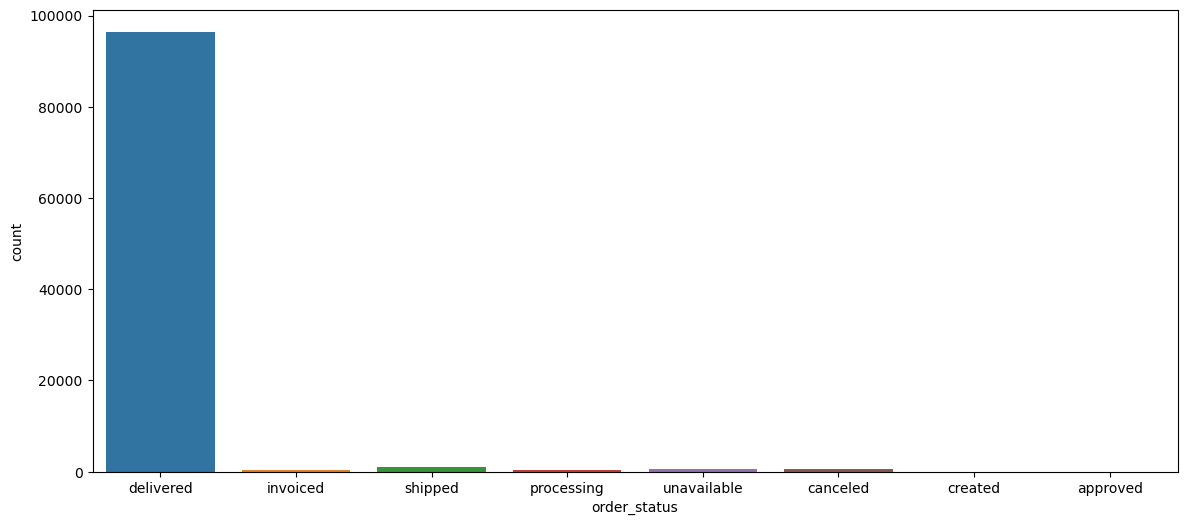

In [8]:
df_orders = olist_orders.merge(olist_customer, how= 'left', on ='customer_id')
fig, ax = plt.subplots(figsize = (14,6))
sns.countplot(df_orders, x='order_status', ax =ax)
plt.show()

In [77]:
## Extract the time data type information from the dataset
timestamp_cols = ['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])

## Extract the attributes
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].dt.year
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].dt.month
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].dt.month_name()
df_orders['order_purchase_quarter'] = df_orders['order_purchase_timestamp'].dt.quarter
df_orders['order_purchase_week_no'] = df_orders['order_purchase_timestamp'].dt.isocalendar().week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].dt.day_name()
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].dt.hour
df_orders['order_purchase_tod'] = df_orders['order_purchase_timestamp'].dt.strftime('%H:%M:%S')
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].dt.strftime('%Y%m')
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].dt.dayofweek
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))



In [78]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_purchase_quarter,order_purchase_week_no,order_purchase_day,order_purchase_hour,order_purchase_tod,order_purchase_year_month,order_purchase_date,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,4,40,Monday,10,10:56:33,201710,20171002,0,Mon,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,3,30,Tuesday,20,20:41:37,201807,20180724,1,Tue,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,3,32,Wednesday,8,08:38:49,201808,20180808,2,Wed,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,4,46,Saturday,19,19:28:06,201711,20171118,5,Sat,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,1,7,Tuesday,21,21:18:39,201802,20180213,1,Tue,Night


In [79]:
## Bins the hours
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn','Morning','Afternoon','Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels = hours_labels) ## review pd.cut code


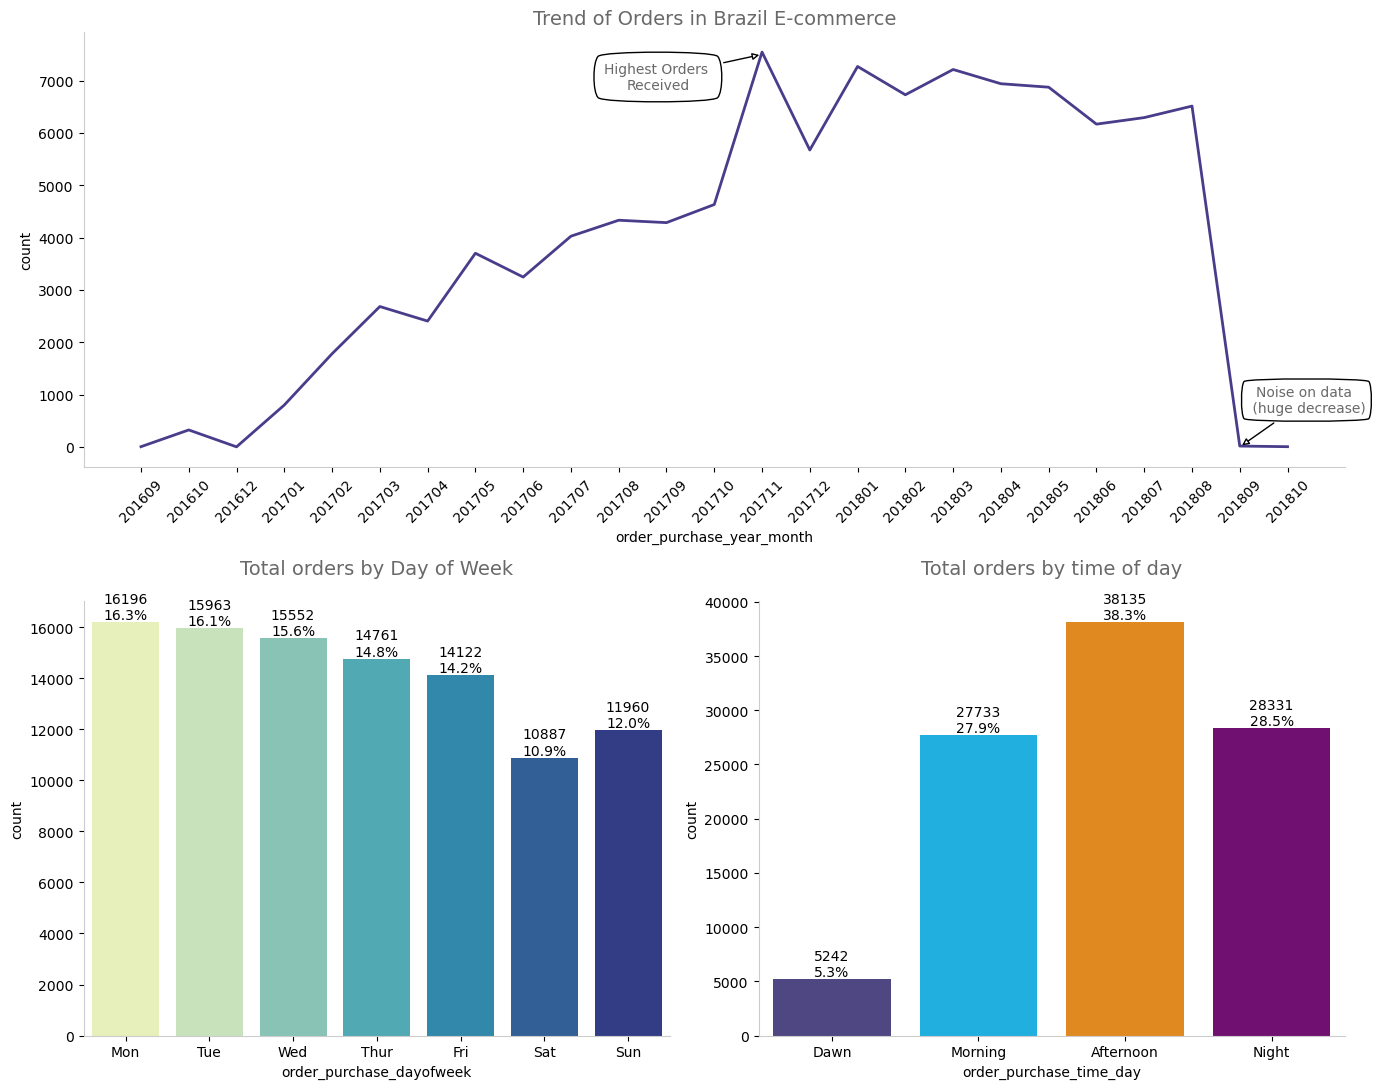

In [80]:
## Creating a figure and GridSpec to collect the visualizations
fig = plt.figure(constrained_layout = True, figsize=(14,11))

## Define the axes
gs = GridSpec(2,2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1 ,0])
ax3 = fig.add_subplot(gs[1, 1])

## Add the plots to the sub-plots
sns.lineplot(data = df_orders['order_purchase_year_month'].value_counts().sort_index(),
            ax = ax1, color = 'darkslateblue', linewidth =2)

ax1.annotate(f'Highest Orders \nReceived', (13,7500),
    xytext=(-75, -25), textcoords = 'offset points', bbox = dict(boxstyle = "round4", fc="w", pad = 0.8),
    arrowprops=dict(arrowstyle='-|>', fc='w'), color = 'dimgrey', ha = 'center'
)

ax1.annotate(f'Noise on data \n (huge decrease)', (23,0), xytext = (48,25),
    textcoords='offset points', bbox = dict(boxstyle="round4", fc="w", pad = 0.5),
    arrowprops=dict(arrowstyle='-|>', fc="w"), color = 'dimgrey', ha ='center'
)

format_spines(ax1, right_border= False)

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Trend of Orders in Brazil E-commerce', size =14, color = 'dimgrey')


## Create a bar chart for total orders by day of week
single_countplot(df_orders, x = 'order_purchase_dayofweek', ax = ax2, order =False, palette='YlGnBu')
weekday_label = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total orders by Day of Week', size = 14, color ='dimgrey', pad = 20)

## Create a bar chart for orders by time of day
day_color_list = ['darkslateblue','deepskyblue','darkorange','purple']
single_countplot(df_orders, x ='order_purchase_time_day', ax = ax3, order = False, palette=day_color_list)
ax3.set_title('Total orders by time of day', size = 14, color = 'dimgrey', pad =20)

plt.tight_layout()
plt.show()

AttributeError: 'numpy.int32' object has no attribute 'startswith'

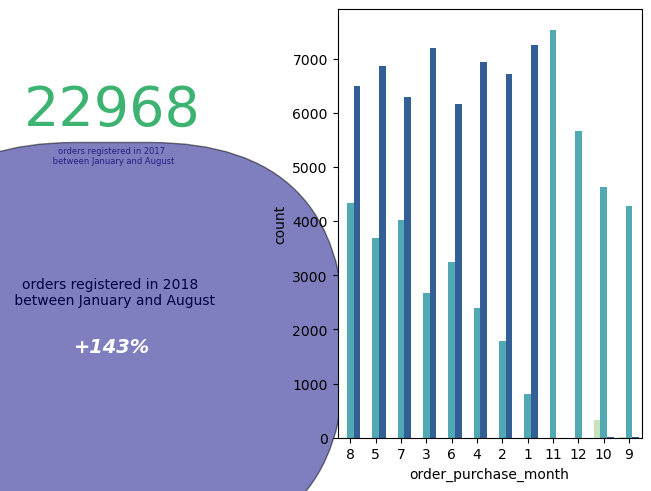

In [81]:
## ---- A comparison between 2017 and 2018
fig = plt.figure(constrained_layout = True)

## Define the axis
gs = GridSpec(1, 3, figure = fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

## Annotation Comparison of Order trends on e-commerce between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017,2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth =  int(round(100 *(1 + year_orders[2017] / year_orders[2018]),0))
ax1.text(0.0, 0.73, f'{year_orders[2017]}', fontsize = 40, color ='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017 \n between January and August', fontsize = 6, color = 'darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018 \n between January and August', fontsize = 10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize = 14, ha='center',color ='white',
        style='italic', weight ='bold', bbox = dict(facecolor = 'navy', alpha =0.5, pad =10, 
                                                    boxstyle ='round'))
ax1.axis('off')

## Bar chart comparison of sales in 2017 and 2018
single_countplot(df_orders, x = 'order_purchase_month', hue ='order_purchase_year',order = True, ax = ax2, palette = 'YlGnBu')
month_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Orders comparison between 2017 and 2018 : January to August',size = 12, color= 'dimgrey', pad =20)
plt.legend(loc = 'lower right')
plt.show()


In [82]:
df_orders[['order_id','order_purchase_year','order_purchase_month','order_purchase_month_name']]

,order_id,order_purchase_year,order_purchase_month,order_purchase_month_name
0,e481f51cbdc54678b7cc49136f2d6af7,2017,10,October
1,53cdb2fc8bc7dce0b6741e2150273451,2018,7,July
2,47770eb9100c2d0c44946d9cf07ec65d,2018,8,August
3,949d5b44dbf5de918fe9c16f97b45f8a,2017,11,November
4,ad21c59c0840e6cb83a9ceb5573f8159,2018,2,February
...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,2017,3,March
99437,63943bddc261676b46f01ca7ac2f7bd8,2018,2,February
99438,83c1379a015df1e13d02aae0204711ab,2017,8,August
99439,11c177c8e97725db2631073c19f07b62,2018,1,January


In [31]:
### USing geo-location to analyze the Brazil e-commerce data
df_orders_items = df_orders.merge(olist_order_items, how ='left', on='order_id')
r = requests.get("https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes")
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis =1, inplace =True)
br_info.drop_duplicates(inplace= True)


## clipping locations to those within the Brazilian map
geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
geo_prep = geo_prep[geo_prep.geolocation_lng <= -34.79314722]

geo_group = geo_prep.groupby(by = 'geolocation_zip_code_prefix', as_index = False).min()

## Merging all information
df_order_items = df_orders_items.merge(br_info, how ='left', left_on ='customer_state', right_on ='sigla')
df_order_items = df_order_items.merge(geo_group, how ='left', 
                    left_on = 'customer_zip_code_prefix',
                    right_on= 'geolocation_zip_code_prefix')

df_orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_purchase_date,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_time_day,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,20171002,0,Mon,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,20180724,1,Tue,Night,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,20180808,2,Wed,Morning,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,20171118,5,Sat,Night,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,20180213,1,Tue,Night,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [34]:
### A summary of the orders by region, state and city
df_orders_filt = df_order_items[(df_order_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

# Groupng the data filter by region
df_regions_group = df_orders_filt.groupby(by=['order_purchase_year_month','nome_regiao'], as_index = False)
df_regions_group = df_regions_group.agg({'customer_id':'count', 'price':'sum'}).sort_values(by='order_purchase_year_month')

df_regions_group.columns = ['month', 'region','order_count','order_amount']
df_regions_group.reset_index(drop = True, inplace= True)

### Group the data by city and get only the top 10 cities
df_cities_group = df_orders_filt.groupby(by="geolocation_city", as_index= False).count().loc[:,['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by='order_id', ascending= False).reset_index(drop = True)
df_cities_group = df_cities_group.iloc[:10, :]

In [35]:
df_cities_group

,geolocation_city,order_id
0,sao paulo,17843
1,rio de janeiro,7843
2,belo horizonte,3162
3,brasilia,2203
4,curitiba,1733
5,campinas,1658
6,porto alegre,1586
7,salvador,1411
8,guarulhos,1328
9,sao bernardo do campo,1102


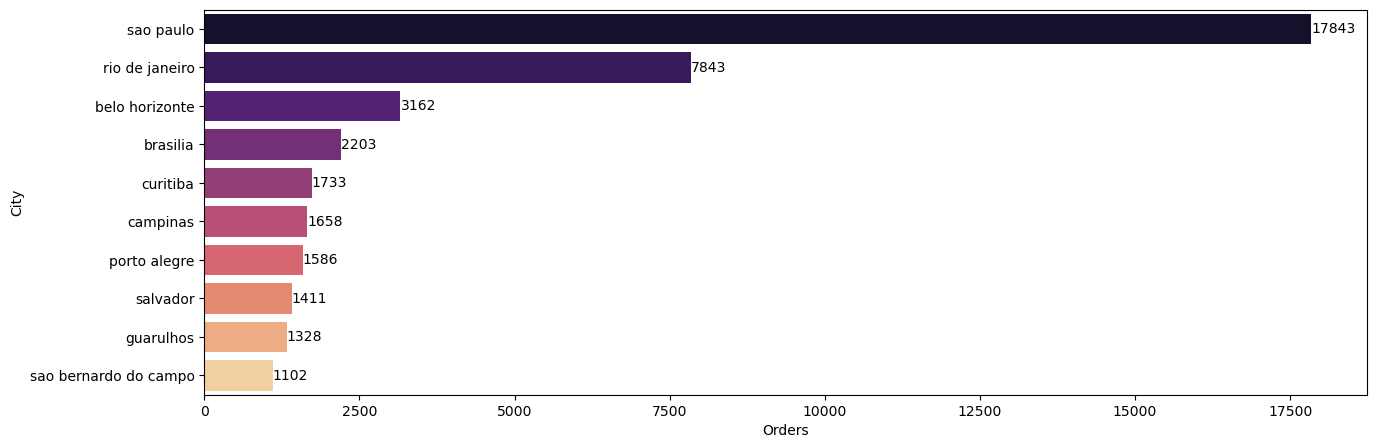

In [62]:
fig, ax = plt.subplots(figsize = (15, 5))
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, palette='magma', ax =ax)
for idx, value in enumerate(df_cities_group['order_id']):
    ax.text(value, idx, str(value), color= 'black', va='center')
ax.set_xlabel('Orders')
ax.set_ylabel('City')
plt.show()

In [ ]:
fig, ax = plt.subplots()

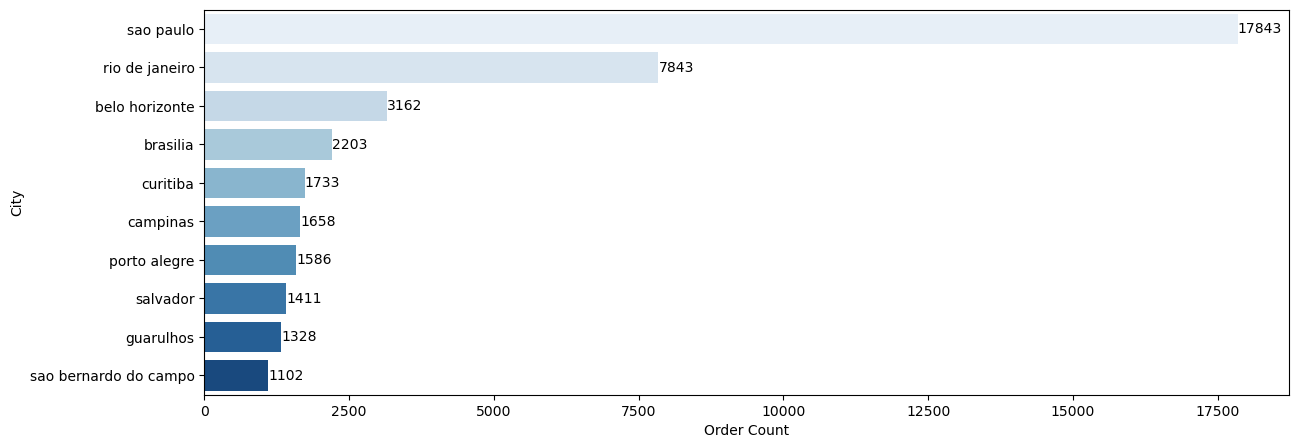

In [60]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 5))

# Create bar plot
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, palette='Blues', ax=ax)

# Annotate each bar with the order_id values
for index, value in enumerate(df_cities_group["order_id"]):
    ax.text(value, index, str(value), color='black', ha="left", va="center")

ax.set_ylabel("City")
ax.set_xlabel("Order Count")
plt.show()